Анализ схожести научных текстов с помощью методов естественной обработки языка и машинного обучения
Береза Анастасия // Учебная группа о.ИЗДтс 23.2/Б3-22

# Обработка естественного языка

## Установка зависимостей


In [1]:
# При первом запуске раскомментировать строку ниже
%pip install kagglehub pandas numpy scikit-learn joblib nltk pymorphy3 matplotlib python-docx pyarrow pdfplumber

## Импорт библиотек


In [2]:
import torch.nn as nn
import torch
import shutil
import re
import random
import pymorphy3
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import kagglehub
import joblib

from typing import Dict

from torch.utils.data import TensorDataset, DataLoader, Dataset

from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.feature_extraction.text import TfidfVectorizer

from pathlib import Path

from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
from nltk import download

from itertools import tee

from collections import defaultdict
from collections import Counter

from docx import Document
import pdfplumber
from datetime import datetime

In [3]:
device = torch.device("cpu")
print("Используемое устройство:", device)

Используемое устройство: cpu


In [4]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    print(f"Зафиксирован seed: {seed}")

## Загрузка датасета

In [5]:
path = kagglehub.dataset_download("ergkerg/russian-scientific-articles")
print("Path to dataset files:", path)

# Копирование в папку проекта

destination_path = os.path.join(os.getcwd(), "russian-scientific-articles")
shutil.copytree(path, destination_path, dirs_exist_ok=True)

print("Файлы датасета перенесены в:", destination_path)

Using Colab cache for faster access to the 'russian-scientific-articles' dataset.
Path to dataset files: /kaggle/input/russian-scientific-articles
Файлы датасета перенесены в: /content/russian-scientific-articles


## Сбор датасета

In [6]:
# Сбор датасета из txt-файлов

rows = []
for root in ["russian-scientific-articles/data_3_1", "russian-scientific-articles/data_3"]:
     for p in Path(root).rglob("*.txt"):
        rows.append({
              "category": p.parent.name,
              "file": str(p),
              "text": p.read_text(encoding="utf-8", errors="ignore")
        })

df = pd.DataFrame(rows)
df.shape


(2478, 3)

In [7]:
# Сохранение в файле

data_dir = Path("data")
data_dir.mkdir(exist_ok=True)

df_path = data_dir / "df.parquet"
df.to_parquet(df_path)

## Загрузка собранного датасета. Анализ

In [8]:
# Загрузка из файла

df = pd.read_parquet("data/df.parquet")
df.head()

category                                               file  \
0  5 Внешняя торговля  russian-scientific-articles/data_3_1/5 Внешняя...   
1  5 Внешняя торговля  russian-scientific-articles/data_3_1/5 Внешняя...   
2  5 Внешняя торговля  russian-scientific-articles/data_3_1/5 Внешняя...   
3  5 Внешняя торговля  russian-scientific-articles/data_3_1/5 Внешняя...   
4  5 Внешняя торговля  russian-scientific-articles/data_3_1/5 Внешняя...   

                                                text  
0  ﻿УДК 339.54 \n\nИонова А.Ю.1\n \n\n \n\n \n\nВ...  
1  ﻿УДК 339.5\n\nМихневич С.И.1\n\nО некоторых ос...  
2  ﻿Электронный научный журнал  \n«ТАМОЖЕННОЕ ДЕЛ...  
3  ﻿Международная торговля\n\nТаможенные особенно...  
4  ﻿ТЕОРИЯ И ПРАКТИКА ТАМОЖЕННОГО ДЕЛА\n\nУДК 620...

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2478 entries, 0 to 2477
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   category  2478 non-null   object
 1   file      2478 non-null   object
 2   text      2478 non-null   object
dtypes: object(3)
memory usage: 58.2+ KB


In [10]:
df.isnull().sum()

category    0
file        0
text        0
dtype: int64

In [11]:
df['text'].describe(include='all')

count                                                  2478
unique                                                 2461
top       ﻿75-летию Ракетно-космической корпорации «Энер...
freq                                                      2
Name: text, dtype: object

In [12]:
df.drop_duplicates(['text',], inplace=True)
df['text'].describe(include='all')

count                                                  2461
unique                                                 2461
top       ﻿Vol. 16\n3\n\n2 0 2 0\n\nMeasurement standard...
freq                                                      1
Name: text, dtype: object

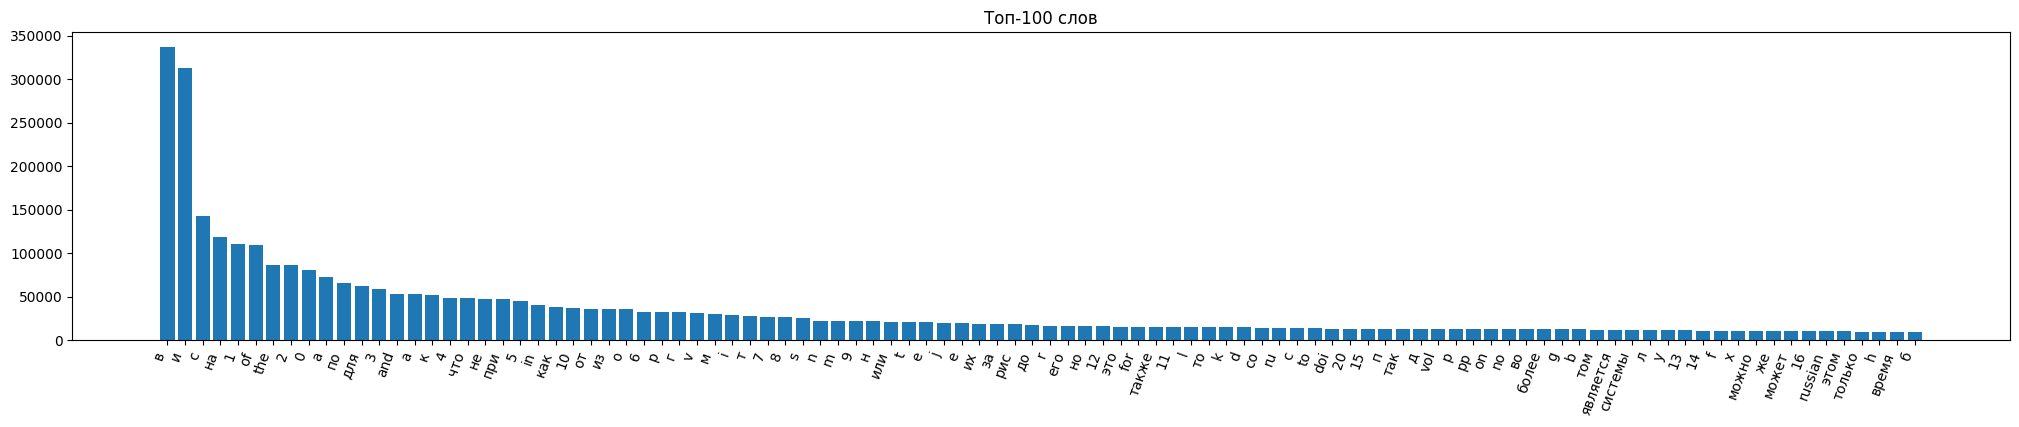

Топ-100 слов:

  1. в                    337259
  2. и                    313366
  3. с                    142198
  4. на                   118276
  5. 1                    110364
  6. of                   109351
  7. the                  86315
  8. 2                    85794
  9. 0                    81057
 10. а                    72737
 11. по                   65267
 12. для                  62789
 13. 3                    58386
 14. and                  52790
 15. a                    52605
 16. к                    52038
 17. 4                    48015
 18. что                  48008
 19. не                   47536
 20. при                  47140
 21. 5                    45442
 22. in                   40814
 23. как                  37713
 24. 10                   37248
 25. от                   36004
 26. из                   35948
 27. о                    35855
 28. 6                    32530
 29. p                    32272
 30. г                    31975
 31. v             

In [13]:
# Извлечение слов из всех статей

def raw_tokens(text):
    return re.findall(r"\w+", str(text).lower())

tokens = []
for article in df["text"].dropna():
    tokens.extend(raw_tokens(article))

# Гистограмма для топ-100 слов

top_n = 100
freq = Counter(tokens).most_common(top_n)
words, counts = zip(*freq)

plt.figure(figsize=(25,4))
plt.bar(words, counts)
plt.xticks(rotation=70, ha="right")
plt.title("Топ-100 слов")
plt.show()

print("Топ-100 слов:\n")
for i, (w, c) in enumerate(zip(words, counts), start=1):
    print(f"{i:3}. {w:<20} {c}")

# Топ пар из 2 слов

def bigrams(seq):
    a, b = tee(seq)
    next(b, None)
    return zip(a, b)

bigram_freq = Counter(bigrams(tokens)).most_common(50)
print("\nТоп 50-биграмм")
for (w1, w2), c in bigram_freq:
    print(f"{w1} {w2}: {c}")

## Очистка текста

In [14]:
# Стоп-слова

download("stopwords", quiet=True)
stop_ru = set(stopwords.words("russian"))
stop_en = set(stopwords.words("english"))
custom_stop = {
    # указатели, ссылки
    "doi","org","orcid","http","https","url","удк",
    # предлоги
    "в","и","с","на","по","для","что","как","от","из","при","но","же","у","о","к",
    # предлоги на англ
    "the","of","in","on","and","a","to","for","is","are",
    # одиночные буквы
    "к","р","п","г","т","е","а","м","н","л","у",
    # цифры
    "0","1","2","3","4","5","6","7","8","9","10","11","12","13","14","15","16","17","18","19","20"
}
custom_bigram_stop = {
    # служебные
    "и в","а также","при этом","а в","на основе","в том","и др","в качестве","так и","что в","не только",
    "но и", "таким образом","том что","том числе","в рамках","в результате","в россии","в виде","в этом",
    "с помощью","на рис",
    # пары чисел
    "1 1","1 2","1 0","2 1","2 2","2 3","2 0",
    "0 0","0 1","0 5","а а","в в","в а",
}
stop_all = stop_ru | stop_en | custom_stop | custom_bigram_stop

morph = pymorphy3.MorphAnalyzer()
english_stemmer = SnowballStemmer("english")

# Учитывать ли латиницу

keep_english = True
min_len = 3

# Сохранять кэш слов

lemma_cache: Dict[str, str] = {}
stem_cache: Dict[str, str] = {}

# Наборы шаблон-выражений

URL_RE = re.compile(r"https?://\S+|www\.\S+", re.IGNORECASE)
EMAIL_RE = re.compile(r"\b[\w.+-]+@[\w-]+\.[\w.-]+\b")
DOI_RE = re.compile(r"\b10\.\d{4,9}/[-._;()/:A-Za-z0-9]+\b", re.IGNORECASE)
ORCID_RE = re.compile(r"\b\d{4}-\d{4}-\d{4}-\d{3}[0-9X]\b")
NUMBER_RE = re.compile(r"\b\d[\d.,/%:-]*\d\b")
TOKEN_RE = re.compile(r"[A-Za-z\u0400-\u04FF]+")
CYRILLIC_RE = re.compile(r"[\u0400-\u04FF]")
LATIN_RE = re.compile(r"[A-Za-z]")

# Функция для очистки по шаблонам

def strip_noise(text: str) -> str:
    text = text.replace("\u00a0", " " ).replace("\ufeff", " " )
    text = URL_RE.sub(" " , text)
    text = EMAIL_RE.sub(" " , text)
    text = DOI_RE.sub(" " , text)
    text = ORCID_RE.sub(" " , text)
    text = NUMBER_RE.sub(" " , text)
    return text

# Функция предобработки текста

def clean_text(raw: str) -> str:
    text = strip_noise(raw.lower())
    lemmas: list[str] = []
    for token in TOKEN_RE.findall(text):
        if len(token) < min_len:
            continue
        has_cyr = bool(CYRILLIC_RE.search(token))
        has_lat = bool(LATIN_RE.search(token))
        if has_cyr and has_lat:
            continue
        if has_cyr:
            lemma = lemma_cache.get(token)
            if lemma is None:
                lemma = morph.parse(token)[0].normal_form
                lemma_cache[token] = lemma
            if len(lemma) >= min_len and lemma not in stop_all:
                lemmas.append(lemma)
        elif has_lat and keep_english:
            stem = stem_cache.get(token)
            if stem is None:
                stem = english_stemmer.stem(token)
                stem_cache[token] = stem
            if len(stem) >= min_len and stem not in stop_all:
                lemmas.append(stem)
    return " ".join(lemmas)

In [15]:
# Предобработка датасета с помощью функции

clean_df = (
    df.assign(clean_text=df["text"].map(clean_text))
      .loc[lambda d: d["clean_text"] != ""]
      .reset_index(drop=True)
)

clean_df.head()


category                                               file  \
0  5 Внешняя торговля  russian-scientific-articles/data_3_1/5 Внешняя...   
1  5 Внешняя торговля  russian-scientific-articles/data_3_1/5 Внешняя...   
2  5 Внешняя торговля  russian-scientific-articles/data_3_1/5 Внешняя...   
3  5 Внешняя торговля  russian-scientific-articles/data_3_1/5 Внешняя...   
4  5 Внешняя торговля  russian-scientific-articles/data_3_1/5 Внешняя...   

                                                text  \
0  ﻿УДК 339.54 \n\nИонова А.Ю.1\n \n\n \n\n \n\nВ...   
1  ﻿УДК 339.5\n\nМихневич С.И.1\n\nО некоторых ос...   
2  ﻿Электронный научный журнал  \n«ТАМОЖЕННОЕ ДЕЛ...   
3  ﻿Международная торговля\n\nТаможенные особенно...   
4  ﻿ТЕОРИЯ И ПРАКТИКА ТАМОЖЕННОГО ДЕЛА\n\nУДК 620...   

                                          clean_text  
0  ионов внедрение стандарт область устойчивый ра...  
1  михневич некоторый особенность либерализация д...  
2  электронный научный журнал таможенный дело вне...  
3  международный торговля таможенный особенность ...  
4  теория практика таможенный дело берлов чадов и...

In [16]:
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2460 entries, 0 to 2459
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   category    2460 non-null   object
 1   file        2460 non-null   object
 2   text        2460 non-null   object
 3   clean_text  2460 non-null   object
dtypes: object(4)
memory usage: 77.0+ KB


In [17]:
clean_df["clean_text"].tolist()

Output hidden; open in https://colab.research.google.com to view.

In [18]:
# Сохранение в файл очищенный набор данных
clean_df.to_json("cleaned_dataset.jsonl", orient="records", lines=True, force_ascii=False)

### Визуализация частоты использования очищенных слов

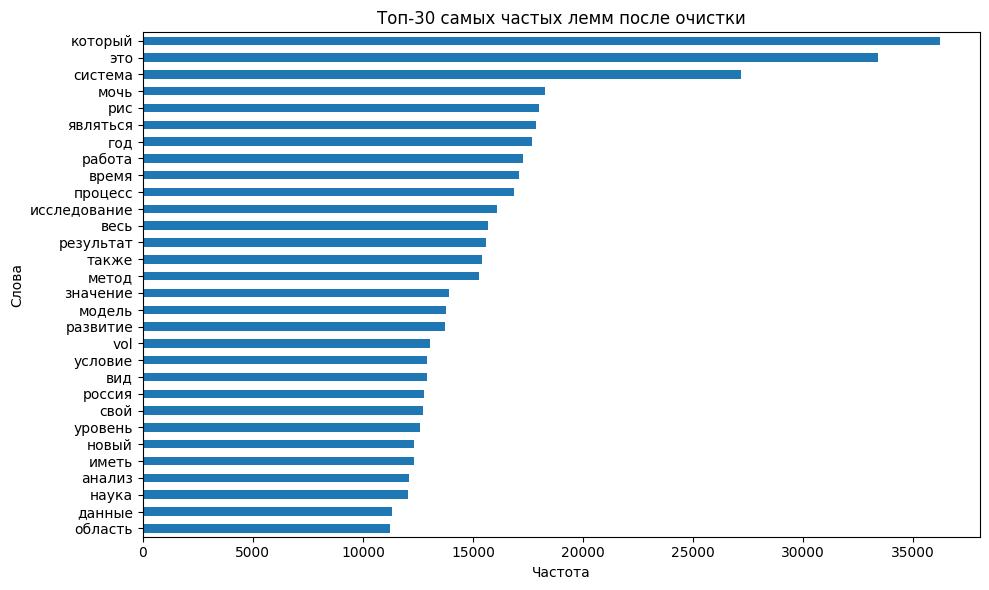

In [19]:
tokens = clean_df["clean_text"].str.split().explode()
freq = tokens.value_counts().head(30)

plt.figure(figsize=(10, 6))
freq.sort_values().plot(kind="barh")
plt.xlabel("Частота")
plt.ylabel("Слова")
plt.title("Топ-30 самых частых лемм после очистки")
plt.tight_layout()
plt.show()

/tmp/ipython-input-3547756974.py:11: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


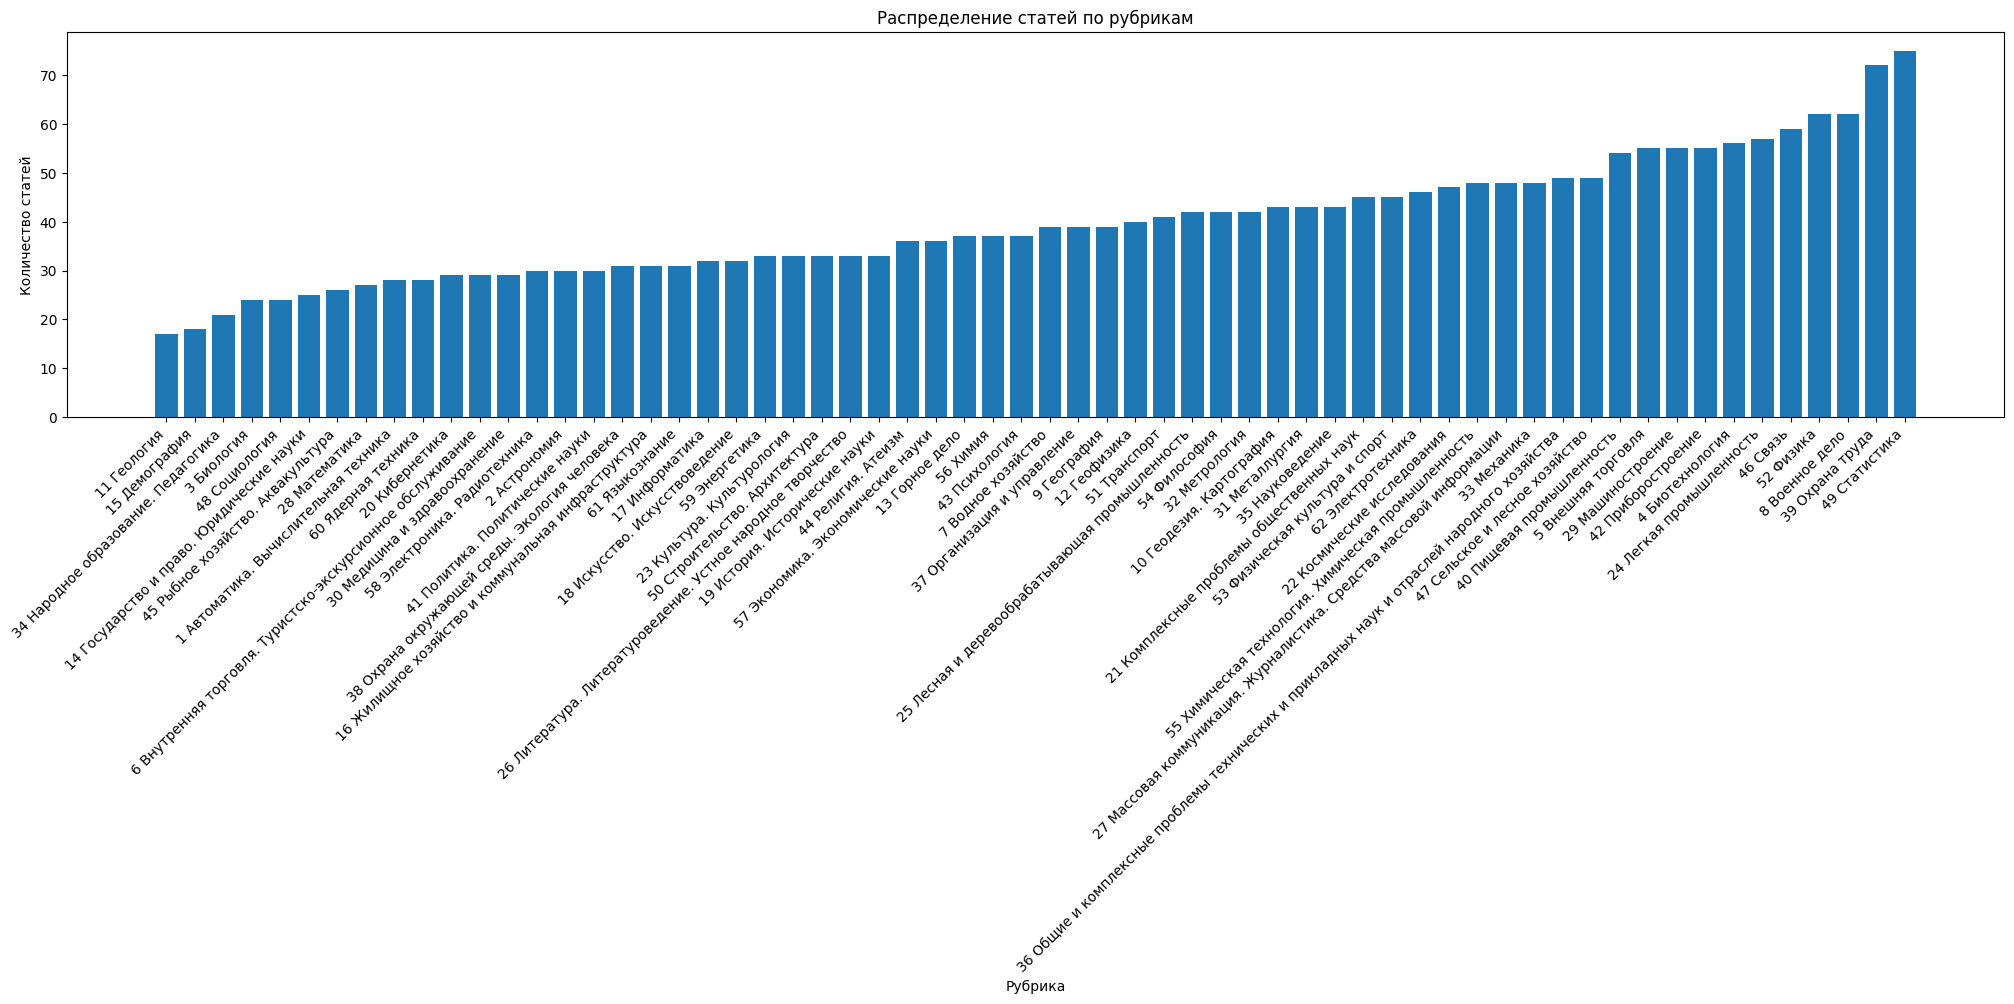

In [20]:
# Количество статей по рубрикам
category_counts = (clean_df["category"].value_counts().sort_values())

# Вывод столбчатой диаграммы
fig, ax = plt.subplots(figsize=(25, 5))
ax.bar(category_counts.index.astype(str), category_counts.values)
ax.set_xlabel("Рубрика")
ax.set_ylabel("Количество статей")
ax.set_title("Распределение статей по рубрикам")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


# Машинное обучение

## Подготовка

In [21]:
# Загрузка набора данных из файла
clean_df = pd.read_json("cleaned_dataset.jsonl", lines=True)
clean_df.head()

category                                               file  \
0  5 Внешняя торговля  russian-scientific-articles/data_3_1/5 Внешняя...   
1  5 Внешняя торговля  russian-scientific-articles/data_3_1/5 Внешняя...   
2  5 Внешняя торговля  russian-scientific-articles/data_3_1/5 Внешняя...   
3  5 Внешняя торговля  russian-scientific-articles/data_3_1/5 Внешняя...   
4  5 Внешняя торговля  russian-scientific-articles/data_3_1/5 Внешняя...   

                                                text  \
0  ﻿УДК 339.54 \n\nИонова А.Ю.1\n \n\n \n\n \n\nВ...   
1  ﻿УДК 339.5\n\nМихневич С.И.1\n\nО некоторых ос...   
2  ﻿Электронный научный журнал  \n«ТАМОЖЕННОЕ ДЕЛ...   
3  ﻿Международная торговля\n\nТаможенные особенно...   
4  ﻿ТЕОРИЯ И ПРАКТИКА ТАМОЖЕННОГО ДЕЛА\n\nУДК 620...   

                                          clean_text  
0  ионов внедрение стандарт область устойчивый ра...  
1  михневич некоторый особенность либерализация д...  
2  электронный научный журнал таможенный дело вне...  
3  международный торговля таможенный особенность ...  
4  теория практика таможенный дело берлов чадов и...

In [22]:
# Разделение на обучающую и валидационную выборку

train_df, test_df = train_test_split(clean_df, test_size=0.2, stratify=clean_df["category"], random_state = 42)

print("Размер train:", train_df.shape)
print("Размер test:", test_df.shape)

Размер train: (1968, 4)
Размер test: (492, 4)


In [23]:
# Векторизация TF-IDF
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2), lowercase=False, min_df=2)

train_texts = train_df["clean_text"].tolist()
test_texts = test_df["clean_text"].tolist()

X_train = vectorizer.fit_transform(train_texts)
X_test = vectorizer.transform(test_texts)

y_train = train_df["category"].astype(str).to_numpy()
y_test = test_df["category"].astype(str).to_numpy()

print("Матрица X_train:", X_train.shape)
print("Матрица X_test:", X_test.shape)

# Сохранение векторизатора для будущего использования
joblib.dump(vectorizer, "tfidf_vectorizer.joblib")

Матрица X_train: (1968, 5000)
Матрица X_test: (492, 5000)


['tfidf_vectorizer.joblib']

In [24]:
print("NNZ train:", X_train.nnz)
print("Среднее число ненулевых признаков на документ:",
      X_train.nnz / X_train.shape[0])

NNZ train: 1365178
Среднее число ненулевых признаков на документ: 693.6880081300814


In [25]:
# Функция создания пар текстов

def make_pairs(X, y, n_pos=3, n_neg=3, random_state= 42):
    rng = np.random.RandomState(random_state)
    y = np.asarray(y)

    label2idx = defaultdict(list)
    for idx, label in enumerate(y):
        label2idx[label].append(idx)

    all_index = np.arange(len(y))
    pair_i = []
    pair_j = []
    pair_labels = []

    for label, idxs in label2idx.items():
        idxs = np.asarray(idxs)
        other_index = np.setdiff1d(all_index, idxs)

        for i in idxs:
            # положительные пары (та же категория)
            if len(idxs) > 1:
                pos_candidates = idxs[idxs != i]
                n_sample_pos = min(n_pos, len(pos_candidates))
                pos = rng.choice(pos_candidates, size=n_sample_pos, replace=False)
                for j in pos:
                    pair_i.append(i)
                    pair_j.append(j)
                    pair_labels.append(1)

            # отрицательные пары (другая категория)
            if len(other_index) > 0:
                n_sample_neg = min(n_neg, len(other_index))
                neg = rng.choice(other_index, size=n_sample_neg, replace=False)
                for j in neg:
                    pair_i.append(i)
                    pair_j.append(j)
                    pair_labels.append(0)

    pair_i = np.asarray(pair_i)
    pair_j = np.asarray(pair_j)
    pair_labels = np.asarray(pair_labels, dtype=int)

    print(f"Сформировано пар: {len(pair_labels)} "
          f"(положительных: {(pair_labels == 1).sum()}, отрицательных: {(pair_labels == 0).sum()})")

    return pair_i, pair_j, pair_labels


# Формирование обучающих и тестовых пар
train_idx_i, train_idx_j, y_train_pairs = make_pairs(X_train, y_train, n_pos=3, n_neg=3, random_state=42)
test_idx_i, test_idx_j, y_test_pairs = make_pairs(X_test, y_test, n_pos=3, n_neg=3, random_state=42)


Сформировано пар: 11808 (положительных: 5904, отрицательных: 5904)
Сформировано пар: 2949 (положительных: 1473, отрицательных: 1476)


## Проектирование модели

### Модель CosineMLP
Принимает один признак - косинус между векторами пары текстов

In [26]:
# Формирование данных в виде косинуса

def pair_cosine_features(X, idx_i, idx_j):
    idx_i = np.asarray(idx_i)
    idx_j = np.asarray(idx_j)
    sims = []
    for a, b in zip(idx_i, idx_j):
        Xi = X[a]
        Xj = X[b]
        sims.append([cosine_similarity(Xi, Xj)[0, 0]])
    return np.array(sims, dtype="float32")

# Генерация признаков для пар

X_train_pairs = pair_cosine_features(X_train, train_idx_i, train_idx_j)
X_test_pairs  = pair_cosine_features(X_test,  test_idx_i,  test_idx_j)

print("Форма X_train_pairs:", X_train_pairs.shape)
print("Форма X_test_pairs :", X_test_pairs.shape)


Форма X_train_pairs: (11808, 1)
Форма X_test_pairs : (2949, 1)


In [27]:
# Тензоры и dataloader для модели

X_train_cos_t = torch.from_numpy(X_train_pairs)
y_train_cos_t = torch.from_numpy(y_train_pairs.astype("float32")).view(-1, 1)

X_test_cos_t  = torch.from_numpy(X_test_pairs)
y_test_cos_t  = torch.from_numpy(y_test_pairs.astype("float32")).view(-1, 1)

cos_train_ds = TensorDataset(X_train_cos_t, y_train_cos_t)
cos_test_ds  = TensorDataset(X_test_cos_t,  y_test_cos_t)

cos_batch_size = 512

cos_train_loader = DataLoader(cos_train_ds, batch_size=cos_batch_size, shuffle=True)
cos_test_loader  = DataLoader(cos_test_ds,  batch_size=cos_batch_size, shuffle=False)


#### Определение архитектуры модели

In [28]:
class CosineMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 16),
            nn.ReLU(),
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Linear(8, 1)
        )

    def forward(self, x):
        return self.net(x)

#### Функция обучения

In [29]:
def train_cosine_model(train_loader, test_loader, device, num_epochs=10):
    model = CosineMLP().to(device)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    history = {
        "train_loss": [],
        "test_loss": [],
        "test_acc": [],
        "test_auc": []
    }

    best_auc = -1.0
    best_state = None
    patience = 3
    no_improve = 0

    for epoch in range(1, num_epochs + 1):
        # Обучение
        model.train()
        train_loss = 0.0

        for xb, yb in train_loader:
            xb = xb.to(device)
            yb = yb.to(device)

            optimizer.zero_grad()
            logits = model(xb)
            loss = criterion(logits, yb)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * xb.size(0)

        train_loss /= len(train_loader.dataset)

        # Тестирование
        model.eval()
        test_loss = 0.0
        all_logits = []
        all_targets = []

        with torch.no_grad():
            for xb, yb in test_loader:
                xb = xb.to(device)
                yb = yb.to(device)

                logits = model(xb)
                loss = criterion(logits, yb)
                test_loss += loss.item() * xb.size(0)

                all_logits.append(logits.cpu())
                all_targets.append(yb.cpu())

        test_loss /= len(test_loader.dataset)

        all_logits = torch.cat(all_logits, dim=0)
        all_targets = torch.cat(all_targets, dim=0)

        proba = torch.sigmoid(all_logits).numpy().reshape(-1)
        true  = all_targets.numpy().reshape(-1)
        pred  = (proba >= 0.5).astype("int32")

        acc = accuracy_score(true, pred)
        auc = roc_auc_score(true, proba)

        history["train_loss"].append(train_loss)
        history["test_loss"].append(test_loss)
        history["test_acc"].append(acc)
        history["test_auc"].append(auc)

        print(f"CosineMLP: Эпоха {epoch}: "
              f"train_loss={train_loss:.4f}  test_loss={test_loss:.4f}  "
              f"Точность={acc:.4f}  AUC={auc:.4f}")

        # Early Stop
        if auc > best_auc:
            best_auc = auc
            best_state = model.state_dict()
            no_improve = 0
        else:
            no_improve += 1
            if no_improve >= patience:
                print(f"AUC не улучшался {patience} эпох(и). Остановка обучения.")
                break

    # Загружаются веса с лучшей эпохи
    if best_state is not None:
        model.load_state_dict(best_state)

    return model, history

# Выполнение
set_seed(42)

cos_model, hist_cos = train_cosine_model(cos_train_loader, cos_test_loader, device, num_epochs=10)


Зафиксирован seed: 42
CosineMLP: Эпоха 1: train_loss=0.7024  test_loss=0.6959  Точность=0.5005  AUC=0.8130
CosineMLP: Эпоха 2: train_loss=0.6925  test_loss=0.6893  Точность=0.5005  AUC=0.8725
CosineMLP: Эпоха 3: train_loss=0.6876  test_loss=0.6854  Точность=0.7677  AUC=0.8725
CosineMLP: Эпоха 4: train_loss=0.6841  test_loss=0.6823  Точность=0.7921  AUC=0.8725
CosineMLP: Эпоха 5: train_loss=0.6805  test_loss=0.6777  Точность=0.8037  AUC=0.8725
CosineMLP: Эпоха 6: train_loss=0.6754  test_loss=0.6725  Точность=0.8043  AUC=0.8725
CosineMLP: Эпоха 7: train_loss=0.6697  test_loss=0.6659  Точность=0.8057  AUC=0.8725
CosineMLP: Эпоха 8: train_loss=0.6625  test_loss=0.6578  Точность=0.8101  AUC=0.8725
CosineMLP: Эпоха 9: train_loss=0.6536  test_loss=0.6479  Точность=0.8074  AUC=0.8725
CosineMLP: Эпоха 10: train_loss=0.6429  test_loss=0.6360  Точность=0.8043  AUC=0.8725
AUC не улучшался 3 эпох(и). Остановка обучения.


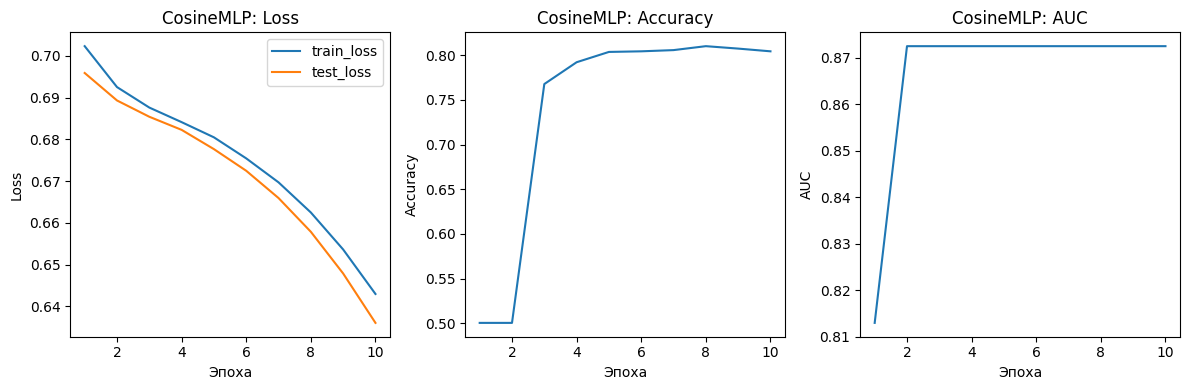

In [30]:
epochs = range(1, len(hist_cos["train_loss"]) + 1)

plt.figure(figsize=(12, 4))

# Loss
plt.subplot(1, 3, 1)
plt.plot(epochs, hist_cos["train_loss"], label="train_loss")
plt.plot(epochs, hist_cos["test_loss"], label="test_loss")
plt.xlabel("Эпоха")
plt.ylabel("Loss")
plt.title("CosineMLP: Loss")
plt.legend()

# Accuracy
plt.subplot(1, 3, 2)
plt.plot(epochs, hist_cos["test_acc"], label="test_acc")
plt.xlabel("Эпоха")
plt.ylabel("Accuracy")
plt.title("CosineMLP: Accuracy")

# AUC
plt.subplot(1, 3, 3)
plt.plot(epochs, hist_cos["test_auc"], label="test_auc")
plt.xlabel("Эпоха")
plt.ylabel("AUC")
plt.title("CosineMLP: AUC")

plt.tight_layout()
plt.show()


In [31]:
# Сохранение модели

os.makedirs("models", exist_ok=True)

torch.save(cos_model.state_dict(), "models/cosine_mlp.pt")


### Модель PairMLP
Принимает два признака - векторы пары текстов

In [32]:
# Формирование признаков: два вектора для каждой пары

def pair_vector_features(X, idx_i, idx_j):
    idx_i = np.asarray(idx_i)
    idx_j = np.asarray(idx_j)
    X1 = X[idx_i].toarray().astype("float32")
    X2 = X[idx_j].toarray().astype("float32")

    return X1, X2

# Генерация признаков для пар (train / test)

X_train_1, X_train_2 = pair_vector_features(X_train, train_idx_i, train_idx_j)
X_test_1, X_test_2 = pair_vector_features(X_test, test_idx_i, test_idx_j)

print("Форма X_train_1:", X_train_1.shape)
print("Форма X_train_2:", X_train_2.shape)
print("Форма X_test_1:", X_test_1.shape)
print("Форма X_test_2:", X_test_2.shape)


Форма X_train_1: (11808, 5000)
Форма X_train_2: (11808, 5000)
Форма X_test_1: (2949, 5000)
Форма X_test_2: (2949, 5000)


In [33]:
class PairVectorDataset(Dataset):
    def __init__(self, X1, X2, y):
        self.X1 = torch.from_numpy(X1)
        self.X2 = torch.from_numpy(X2)
        self.y = torch.from_numpy(y.astype("float32")).view(-1, 1)

    def __len__(self):
        return self.y.shape[0]

    def __getitem__(self, idx):
        return self.X1[idx], self.X2[idx], self.y[idx]


pair_batch_size = 512

train_pair_ds = PairVectorDataset(X_train_1, X_train_2, y_train_pairs)
test_pair_ds= PairVectorDataset(X_test_1,X_test_2,y_test_pairs)

train_pair_loader = DataLoader(train_pair_ds, batch_size=pair_batch_size, shuffle=True)
test_pair_loader = DataLoader(test_pair_ds, batch_size=pair_batch_size, shuffle=False)


#### Определение архитектуры модели

In [34]:
class PairMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim=256, dropout_p=0.3):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout_p),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Linear(hidden_dim // 2, 1)
        )

    def forward(self, x1, x2):
        x = torch.cat([x1, x2], dim=1)
        return self.net(x)

#### Обучение

In [35]:
# Сколько входных признаков

input_dim = X_train.shape[1]
print("Размер TF-IDF признакового пространства:", input_dim)

Размер TF-IDF признакового пространства: 5000


In [36]:
def train_pair_mlp(train_loader, test_loader, device, input_dim, num_epochs=10):
    model = PairMLP(input_dim=input_dim).to(device)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    history = {
        "train_loss": [],
        "test_loss": [],
        "test_acc": [],
        "test_auc": []
    }

    best_auc = -1.0
    best_state = None
    patience = 3
    no_improve = 0

    for epoch in range(1, num_epochs + 1):
        # Обучение
        model.train()
        total_train_loss = 0.0

        for xb1, xb2, yb in train_loader:
            xb1 = xb1.to(device)
            xb2 = xb2.to(device)
            yb = yb.to(device)

            optimizer.zero_grad()
            logits = model(xb1, xb2)
            loss = criterion(logits, yb)
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item() * xb1.size(0)

        train_loss = total_train_loss / len(train_loader.dataset)

        # Тестирование
        model.eval()
        total_test_loss = 0.0
        all_logits = []
        all_targets = []

        with torch.no_grad():
            for xb1, xb2, yb in test_loader:
                xb1 = xb1.to(device)
                xb2 = xb2.to(device)
                yb = yb.to(device)

                logits = model(xb1, xb2)
                loss = criterion(logits, yb)
                total_test_loss += loss.item() * xb1.size(0)

                all_logits.append(logits.cpu())
                all_targets.append(yb.cpu())

        test_loss = total_test_loss / len(test_loader.dataset)

        all_logits = torch.cat(all_logits, dim=0)
        all_targets = torch.cat(all_targets, dim=0)

        proba = torch.sigmoid(all_logits).numpy().reshape(-1)
        true = all_targets.numpy().reshape(-1)
        pred = (proba >= 0.5).astype("int32")

        acc = accuracy_score(true, pred)
        auc = roc_auc_score(true, proba)

        history["train_loss"].append(train_loss)
        history["test_loss"].append(test_loss)
        history["test_acc"].append(acc)
        history["test_auc"].append(auc)

        print(
            f"PairMLP: Эпоха {epoch}: "
            f"train_loss={train_loss:.4f} test_loss={test_loss:.4f} "
            f"Точность={acc:.4f} AUC={auc:.4f}"
        )

        # early stopping по AUC
        if auc > best_auc:
            best_auc = auc
            best_state = model.state_dict()
            no_improve = 0
        else:
            no_improve += 1
            if no_improve >= patience:
                print(f"AUC не улучшался {patience} эпох(и). Остановка обучения.")
                break

    if best_state is not None:
        model.load_state_dict(best_state)

    return model, history

set_seed(42)

input_dim = X_train.shape[1]

pair_model, hist_pair = train_pair_mlp(train_pair_loader, test_pair_loader, device, input_dim=input_dim, num_epochs=40)


Зафиксирован seed: 42
PairMLP: Эпоха 1: train_loss=0.6914 test_loss=0.6818 Точность=0.6640 AUC=0.7342
PairMLP: Эпоха 2: train_loss=0.6457 test_loss=0.5917 Точность=0.7053 AUC=0.7888
PairMLP: Эпоха 3: train_loss=0.4942 test_loss=0.4869 Точность=0.7714 AUC=0.8482
PairMLP: Эпоха 4: train_loss=0.3370 test_loss=0.4508 Точность=0.8006 AUC=0.8744
PairMLP: Эпоха 5: train_loss=0.2193 test_loss=0.4297 Точность=0.8220 AUC=0.8937
PairMLP: Эпоха 6: train_loss=0.1369 test_loss=0.4534 Точность=0.8182 AUC=0.9017
PairMLP: Эпоха 7: train_loss=0.0847 test_loss=0.4566 Точность=0.8338 AUC=0.9079
PairMLP: Эпоха 8: train_loss=0.0564 test_loss=0.5091 Точность=0.8243 AUC=0.9103
PairMLP: Эпоха 9: train_loss=0.0347 test_loss=0.5129 Точность=0.8325 AUC=0.9140
PairMLP: Эпоха 10: train_loss=0.0239 test_loss=0.5287 Точность=0.8372 AUC=0.9150
PairMLP: Эпоха 11: train_loss=0.0184 test_loss=0.5343 Точность=0.8366 AUC=0.9174
PairMLP: Эпоха 12: train_loss=0.0178 test_loss=0.5673 Точность=0.8359 AUC=0.9187
PairMLP: Эпоха 

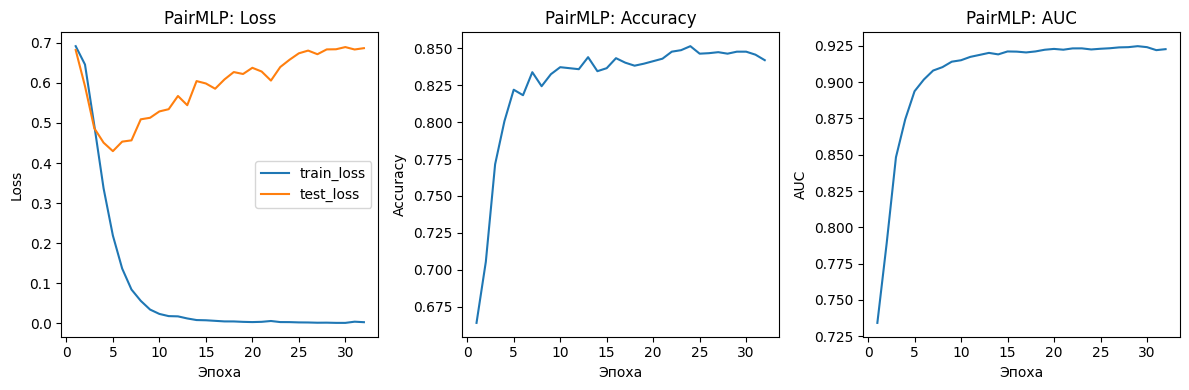

In [37]:
epochs = range(1, len(hist_pair["train_loss"]) + 1)

plt.figure(figsize=(12, 4))

# Loss
plt.subplot(1, 3, 1)
plt.plot(epochs, hist_pair["train_loss"], label="train_loss")
plt.plot(epochs, hist_pair["test_loss"], label="test_loss")
plt.xlabel("Эпоха")
plt.ylabel("Loss")
plt.title("PairMLP: Loss")
plt.legend()

# Accuracy
plt.subplot(1, 3, 2)
plt.plot(epochs, hist_pair["test_acc"], label="test_acc")
plt.xlabel("Эпоха")
plt.ylabel("Accuracy")
plt.title("PairMLP: Accuracy")

# AUC
plt.subplot(1, 3, 3)
plt.plot(epochs, hist_pair["test_auc"], label="test_auc")
plt.xlabel("Эпоха")
plt.ylabel("AUC")
plt.title("PairMLP: AUC")

plt.tight_layout()
plt.show()


In [38]:
os.makedirs("models", exist_ok=True)
torch.save(pair_model.state_dict(), "models/pair_mlp.pt")


# Тестирование

In [39]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Используемое устройство:", device)

# Загрузка TF-IDF векторизатора
vectorizer = joblib.load("tfidf_vectorizer.joblib")

# Определяем размерность TF-IDF-признаков
tfidf_dim = vectorizer.transform(["тестовая строка"]).shape[1]
print("Размерность TF-IDF:", tfidf_dim)

# Загрузка модели CosineMLP
cos_model = CosineMLP().to(device)
cos_model.load_state_dict(torch.load("models/cosine_mlp.pt", map_location=device))
cos_model.eval()

# Загрузка модели PairMLP

pair_model = PairMLP(input_dim=tfidf_dim).to(device)
pair_model.load_state_dict(torch.load("models/pair_mlp.pt", map_location=device))
pair_model.eval()

print("Модели загружены.")

Используемое устройство: cpu
Размерность TF-IDF: 5000
Модели загружены.


In [40]:
# Функция  подготовки пары текстов для CosineMLP

def prepare_tfidf_pair_cosine(text1: str, text2: str):
    clean1 = clean_text(text1)
    clean2 = clean_text(text2)

    # Проверка пустого текста
    if clean1.strip() == "" or clean2.strip() == "":
        print("Внимание: один из текстов после очистки оказался пустым.")

    X_pair = vectorizer.transform([clean1, clean2])
    x1 = X_pair[0]
    x2 = X_pair[1]
    return x1, x2, clean1, clean2

# Функция  подготовки пары текстов для PairMLP

def prepare_tfidf_pair_twovectors(text1: str, text2: str):
    clean1 = clean_text(text1)
    clean2 = clean_text(text2)

    if clean1.strip() == "" or clean2.strip() == "":
        print("Внимание: один из текстов после очистки оказался пустым.")

    X_pair = vectorizer.transform([clean1, clean2]).toarray().astype("float32")
    x1 = torch.from_numpy(X_pair[0:1]).to(device)
    x2 = torch.from_numpy(X_pair[1:1+1]).to(device)

    return x1, x2, clean1, clean2


In [41]:
# Использование cosineMLP для анализа текстов

def predict_with_cosine_mlp(text1: str, text2: str, threshold: float = 0.5):

    x1, x2, clean1, clean2 = prepare_tfidf_pair_cosine(text1, text2)

    # Косинусное сходство между TF-IDF векторами
    cos = float(cosine_similarity(x1, x2)[0, 0])

    # Преобразуем в тензор формы (1, 1)
    inp = torch.tensor([[cos]], dtype=torch.float32, device=device)

    cos_model.eval()
    with torch.no_grad():
        logit = cos_model(inp)
        prob = torch.sigmoid(logit).item()

    label = int(prob >= threshold)
    return prob, label, cos

# Использование pairMLP для анализа

def predict_with_pair_mlp(text1: str, text2: str, threshold: float = 0.5):
    x1_t, x2_t, clean1, clean2 = prepare_tfidf_pair_twovectors(text1, text2)

    pair_model.eval()
    with torch.no_grad():
        logit = pair_model(x1_t, x2_t)
        prob = torch.sigmoid(logit).item()

    label = int(prob >= threshold)
    return prob, label


In [42]:
# Открыт в google.colab или нет

def in_colab() -> bool:
    try:
        import google.colab  # noqa: F401
        return True
    except Exception:
        return False

# Выбор файла
def pick_file(label: str) -> str | None:
    if in_colab():
        from google.colab import files
        print(f"\nЗагрузите файл для: {label} (txt/pdf/docx)")
        uploaded = files.upload()
        if not uploaded:
            return None
        return next(iter(uploaded.keys()))  # файл окажется в текущей директории (/content)
    else:
        path = input(f"\nВведите путь к файлу для '{label}' (txt/pdf/docx) или Enter для выхода:\n> ").strip()
        if not path:
            return None
        p = Path(path)
        if not p.exists():
            print("Файл не найден.")
            return None
        return str(p)

# Чтение текста из файла
def read_text(file_path: str) -> str | None:
    fp = file_path.lower()

    if fp.endswith(".txt"):
        with open(file_path, "r", encoding="utf-8", errors="ignore") as f:
            return f.read()

    if fp.endswith(".pdf"):
        #
        with pdfplumber.open(file_path) as pdf:
            return "\n".join((page.extract_text() or "") for page in pdf.pages)

    if fp.endswith(".docx"):
        #
        doc = Document(file_path)
        return "\n".join(p.text for p in doc.paragraphs)

    print("Неподдерживаемый формат. Нужны: txt / pdf / docx")
    return None

# Обобщение функций выбора файла и чтения из него текста
def get_text(label: str):
    file_path = pick_file(label)
    if file_path is None:
        return None, None

    text = read_text(file_path)
    if text is None or not text.strip():
        print("Не удалось извлечь текст или файл пустой.")
        return None, None

    return text, file_path

# Создание отчёта для сохрнения результатов
def save_comparison_report(text_a_source:str, text_b_source:str, prob_cos:float, label_cos:int, cos:float, prob_pair:float, label_pair:int, report_path:str = "reports/comparison_report.txt"):

    report_path = Path(report_path)
    report_path.parent.mkdir(parents=True, exist_ok=True)
    ts = datetime.now().strftime("%Y-%m-%d %H:%M:%S")

    with open(report_path, "a", encoding="utf-8") as f:
        f.write("=" * 80 + "\n")
        f.write(f"Время сравнения: {ts}\n")
        f.write(f"Источник текста A: {text_a_source}\n")
        f.write(f"Источник текста B: {text_b_source}\n\n")

        f.write("Модель CosineMLP\n")
        f.write(f"Косинусное сходство: {cos:.4f}\n")
        f.write(f"Вероятность схожести: {prob_cos:.4f}\n")
        f.write(
            "Решение: "
            + ("Похожие" if label_cos == 1 else "Не похожие")
            + "\n\n"
        )

        f.write("Модель PairMLP\n")
        f.write(f"Вероятность схожести: {prob_pair:.4f}\n")
        f.write(
            "Решение: "
            + ("Похожие" if label_pair == 1 else "Не похожие")
            + "\n\n"
        )

    print(f"\nРезультаты сравнения сохранены в отчёт: {report_path}")

In [43]:
if __name__ == "__main__":
    # Первый текст
    text_a, src_a = get_text("первый текст")
    if text_a is None:
        print("Работа программы завершена.")
        raise SystemExit(0)

    # Второй текст
    text_b, src_b = get_text("второй текст")
    if text_b is None:
        print("Работа программы завершена.")
        raise SystemExit(0)

    # CosineMLP
    print("\nМодель CosineMLP")
    prob_cos, label_cos, cos = predict_with_cosine_mlp(text_a, text_b)
    print(f"Косинусное сходство: {cos:.4f}")
    print(f"Вероятность схожести: {prob_cos:.4f}")
    print("Решение:", "Похожие" if label_cos == 1 else "Не похожие")

    # PairMLP
    print("\nМодель PairMLP")
    prob_pair, label_pair = predict_with_pair_mlp(text_a, text_b)
    print(f"Вероятность схожести: {prob_pair:.4f}")
    print("Решение:", "Похожие" if label_pair == 1 else "Не похожие")

    # Отчёт
    save_comparison_report(
        text_a_source=src_a,
        text_b_source=src_b,
        prob_cos=prob_cos,
        label_cos=label_cos,
        cos=cos,
        prob_pair=prob_pair,
        label_pair=label_pair,
        report_path="reports/comparison_report.txt"
    )


Загрузите файл для: первый текст (txt/pdf/docx)


Saving algoritmy-mashinnogo-obucheniya.pdf to algoritmy-mashinnogo-obucheniya (1).pdf

Загрузите файл для: второй текст (txt/pdf/docx)


Saving printsipy-mashinnogo-obucheniya.pdf to printsipy-mashinnogo-obucheniya (1).pdf

Модель CosineMLP
Косинусное сходство: 0.8191
Вероятность схожести: 0.7338
Решение: Похожие

Модель PairMLP
Вероятность схожести: 0.9829
Решение: Похожие

Результаты сравнения сохранены в отчёт: reports/comparison_report.txt
